# Modelisation Pression

In [2]:
import os
import numpy as np
import pandas as pd
import joblib

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

INPUT = "../datas/processed/capteur_C013_features.csv"
MODEL_DIR = "../models"
FIG_DIR = "../reports/figures"
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

pd.set_option("display.max_columns", 200)

In [3]:
df = pd.read_csv(INPUT, parse_dates=["timestamp"])
df = df.sort_values("timestamp").reset_index(drop=True)
df.head()

,timestamp,nom_salle,capacite_salle,temperature,temperature_ext,humidite,pression,nb_eleves_presents,jour,heure,minute,jour_semaine,est_weekend,salle_ouverte,heure_sin,heure_cos,ratio_occupation,ecart_temp_int_ext,ouvert_x_occupation,delta_temperature,delta_humidite,delta_pression,delta_temperature_ext,delta_occupation,temperature_lag1,temperature_lag2,temperature_ext_lag1,temperature_ext_lag2,humidite_lag1,humidite_lag2,pression_lag1,pression_lag2,nb_eleves_presents_lag1,nb_eleves_presents_lag2,temperature_moy_gliss_2,temperature_moy_gliss_6,temperature_ext_moy_gliss_2,temperature_ext_moy_gliss_6,humidite_moy_gliss_2,humidite_moy_gliss_6,nb_eleves_presents_moy_gliss_2,nb_eleves_presents_moy_gliss_6
0,2025-08-20 22:00:00,C013,30,32.0,34.7,35.5,1014.8,0,2025-08-20,22,0,2,0,0,-0.500000,0.866025,0.0,-2.7,0,-1.0,0.1,0.1,-1.7,0.0,32.0,32.0,34.7,34.7,35.5,35.5,1014.8,1014.8,0.0,0.0,32.00,32.000000,34.70,34.700000,35.50,35.500000,0.0,0.0
1,2025-08-20 22:30:00,C013,30,31.0,33.0,35.6,1014.9,0,2025-08-20,22,30,2,0,0,-0.382683,0.923880,0.0,-2.0,0,-1.0,0.1,0.1,-1.7,0.0,32.0,32.0,34.7,34.7,35.5,35.5,1014.8,1014.8,0.0,0.0,31.50,31.500000,33.85,33.850000,35.55,35.550000,0.0,0.0
2,2025-08-20 23:00:00,C013,30,30.7,33.0,40.3,1014.7,0,2025-08-20,23,0,2,0,0,-0.258819,0.965926,0.0,-2.3,0,-0.3,4.7,-0.2,0.0,0.0,31.0,32.0,33.0,34.7,35.6,35.5,1014.9,1014.8,0.0,0.0,30.85,31.233333,33.00,33.566667,37.95,37.133333,0.0,0.0
3,2025-08-20 23:30:00,C013,30,29.9,31.7,36.6,1014.5,0,2025-08-20,23,30,2,0,0,-0.130526,0.991445,0.0,-1.8,0,-0.8,-3.7,-0.2,-1.3,0.0,30.7,31.0,33.0,33.0,40.3,35.6,1014.7,1014.9,0.0,0.0,30.30,30.900000,32.35,33.100000,38.45,37.000000,0.0,0.0
4,2025-08-21 00:00:00,C013,30,29.9,31.0,40.6,1014.5,0,2025-08-21,0,0,3,0,0,0.000000,1.000000,0.0,-1.1,0,0.0,4.0,0.0,-0.7,0.0,29.9,30.7,31.7,33.0,36.6,40.3,1014.5,1014.7,0.0,0.0,29.90,30.700000,31.35,32.680000,38.60,37.720000,0.0,0.0


In [5]:
H1, H2 = 2, 4
df["pression_t+2"] = df["pression"].shift(-H1)
df["pression_t+4"] = df["pression"].shift(-H2)

df["dP_t+2"] = df["pression_t+2"] - df["pression"]
df["dP_t+4"] = df["pression_t+4"] - df["pression"]

df_model = df.dropna(subset=["pression_t+2", "pression_t+4"]).reset_index(drop=True)
df_model.shape


(332, 46)

In [6]:
feature_cols = [
    "temperature",
    "temperature_ext",
    "humidite",
    "pression",
    "nb_eleves_presents",
    "salle_ouverte",
    "heure_sin",
    "heure_cos",
    "jour_semaine",
    "est_weekend",
    "temperature_lag1",
    "temperature_lag2",
    "temperature_ext_lag1",
    "temperature_ext_lag2",
    "humidite_lag1",
    "humidite_lag2",
    "pression_lag1",
    "pression_lag2",
    "nb_eleves_presents_lag1",
    "nb_eleves_presents_lag2",
    "temperature_moy_gliss_2",
    "temperature_moy_gliss_6",
    "temperature_ext_moy_gliss_2",
    "temperature_ext_moy_gliss_6",
    "humidite_moy_gliss_2",
    "humidite_moy_gliss_6",
    "nb_eleves_presents_moy_gliss_2",
    "nb_eleves_presents_moy_gliss_6",
    "ratio_occupation",
    "ecart_temp_int_ext",
    "ouvert_x_occupation",
]

target_cols = ["pression_t+2", "pression_t+4"]
target_cols_d = ["dP_t+2", "dP_t+4"]

X = df_model[feature_cols].copy()
Y = df_model[target_cols].copy()
Yd = df_model[target_cols_d].copy()

X.shape, Y.shape, Yd.shape


((332, 31), (332, 2), (332, 2))

In [7]:
def eval_regression(y_true: pd.DataFrame, y_pred: np.ndarray, label=""):
    cols = list(y_true.columns)
    print(f"\nÉvaluation {label}")
    for i, col in enumerate(cols):
        y_t, y_p = y_true.iloc[:, i].to_numpy(), y_pred[:, i]
        mae = mean_absolute_error(y_t, y_p)
        rmse = root_mean_squared_error(y_t, y_p)
        print(f"{col:>16s} | MAE: {mae:.1f} | RMSE: {rmse:.1f}")

tscv = TimeSeriesSplit(n_splits=5)


In [8]:
def fit_eval_ridge(X, Y, model_name="ridge_pression_levels"):
    for fold, (tr, te) in enumerate(tscv.split(X), 1):
        pipe = Pipeline(
            [
                ("scaler", StandardScaler()),
                ("reg", MultiOutputRegressor(Ridge(alpha=1.0, random_state=42))),
            ]
        )
        pipe.fit(X.iloc[tr], Y.iloc[tr])
        y_pred = pipe.predict(X.iloc[te])
        eval_regression(Y.iloc[te], y_pred, label=f"{model_name} - fold {fold}")
    pipe.fit(X, Y)
    path = os.path.join(MODEL_DIR, f"{model_name}.joblib")
    joblib.dump(pipe, path)
    return pipe


ridge_levels = fit_eval_ridge(X, Y, model_name="ridge_pression_levels")
ridge_deltas = fit_eval_ridge(X, Yd, model_name="ridge_pression_deltas")



Évaluation ridge_pression_levels - fold 1
    pression_t+2 | MAE: 0.4 | RMSE: 0.5
    pression_t+4 | MAE: 0.7 | RMSE: 0.9

Évaluation ridge_pression_levels - fold 2
    pression_t+2 | MAE: 0.5 | RMSE: 0.5
    pression_t+4 | MAE: 0.8 | RMSE: 0.9

Évaluation ridge_pression_levels - fold 3
    pression_t+2 | MAE: 0.4 | RMSE: 0.5
    pression_t+4 | MAE: 0.7 | RMSE: 0.9

Évaluation ridge_pression_levels - fold 4
    pression_t+2 | MAE: 0.4 | RMSE: 0.5
    pression_t+4 | MAE: 0.6 | RMSE: 0.8

Évaluation ridge_pression_levels - fold 5
    pression_t+2 | MAE: 0.3 | RMSE: 0.4
    pression_t+4 | MAE: 0.4 | RMSE: 0.5

Évaluation ridge_pression_deltas - fold 1
          dP_t+2 | MAE: 0.4 | RMSE: 0.5
          dP_t+4 | MAE: 0.7 | RMSE: 0.9

Évaluation ridge_pression_deltas - fold 2
          dP_t+2 | MAE: 0.4 | RMSE: 0.5
          dP_t+4 | MAE: 0.7 | RMSE: 0.8

Évaluation ridge_pression_deltas - fold 3
          dP_t+2 | MAE: 0.4 | RMSE: 0.5
          dP_t+4 | MAE: 0.7 | RMSE: 0.9

Évaluation ridg

In [9]:
BEST_RF_PARAMS = dict(
    n_estimators=400,
    max_depth=20,
    min_samples_leaf=1,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1,
)


def fit_eval_rf_tuned(X, Y, model_name="rf_pression_levels_tuned"):
    for fold, (tr, te) in enumerate(tscv.split(X), 1):
        rf = MultiOutputRegressor(RandomForestRegressor(**BEST_RF_PARAMS))
        rf.fit(X.iloc[tr], Y.iloc[tr])
        y_pred = rf.predict(X.iloc[te])
        eval_regression(Y.iloc[te], y_pred, label=f"{model_name} - fold {fold}")

    rf.fit(X, Y)
    path = os.path.join(MODEL_DIR, f"{model_name}.joblib")
    joblib.dump(rf, path)
    print("Modèle sauvegardé :", path)
    return rf


rf_levels = fit_eval_rf_tuned(X, Y, model_name="rf_pression_levels_tuned")
rf_deltas = fit_eval_rf_tuned(X, Yd, model_name="rf_pression_deltas_tuned")



Évaluation rf_pression_levels_tuned - fold 1
    pression_t+2 | MAE: 0.8 | RMSE: 1.0
    pression_t+4 | MAE: 0.8 | RMSE: 1.0

Évaluation rf_pression_levels_tuned - fold 2
    pression_t+2 | MAE: 1.9 | RMSE: 2.2
    pression_t+4 | MAE: 1.9 | RMSE: 2.3

Évaluation rf_pression_levels_tuned - fold 3
    pression_t+2 | MAE: 0.8 | RMSE: 1.0
    pression_t+4 | MAE: 0.8 | RMSE: 0.9

Évaluation rf_pression_levels_tuned - fold 4
    pression_t+2 | MAE: 0.6 | RMSE: 0.7
    pression_t+4 | MAE: 0.9 | RMSE: 1.0

Évaluation rf_pression_levels_tuned - fold 5
    pression_t+2 | MAE: 0.5 | RMSE: 0.6
    pression_t+4 | MAE: 0.5 | RMSE: 0.7
Modèle sauvegardé : ../models/rf_pression_levels_tuned.joblib

Évaluation rf_pression_deltas_tuned - fold 1
          dP_t+2 | MAE: 0.3 | RMSE: 0.4
          dP_t+4 | MAE: 0.6 | RMSE: 0.7

Évaluation rf_pression_deltas_tuned - fold 2
          dP_t+2 | MAE: 0.4 | RMSE: 0.5
          dP_t+4 | MAE: 0.6 | RMSE: 0.7

Évaluation rf_pression_deltas_tuned - fold 3
          

In [10]:
MODEL_LVL_PATH = os.path.join(MODEL_DIR, "rf_pression_levels_tuned.joblib")
MODEL_DELTA_PATH = os.path.join(MODEL_DIR, "rf_pression_deltas_tuned.joblib")

model_levels = joblib.load(MODEL_LVL_PATH)
model_deltas = joblib.load(MODEL_DELTA_PATH)

target_cols, target_cols_d


(['pression_t+2', 'pression_t+4'], ['dP_t+2', 'dP_t+4'])

In [11]:
def predire_pression(df_features_courant: pd.DataFrame):
    
    assert all(col in df_features_courant.columns for col in X.columns), (
        "Les features d'entrée ne correspondent pas au jeu d'entraînement."
    )

    x_last = df_features_courant[X.columns].iloc[[-1]]

    y_levels = model_levels.predict(x_last)[0]
    y_deltas = model_deltas.predict(x_last)[0]

    return {
        "niveaux": {
            "pression_t+1h": round(float(y_levels[0]), 1),
            "pression_t+2h": round(float(y_levels[1]), 1),
        },
        "deltas": {
            "dP_+1h": round(float(y_deltas[0]), 1),
            "dP_+2h": round(float(y_deltas[1]), 1),
        },
    }


In [12]:
fold_indices = list(tscv.split(X))
train_idx, test_idx = fold_indices[-1]

Xte = X.iloc[test_idx]
Yte = Y.iloc[test_idx]
timestamps_test = df_model.loc[test_idx, "timestamp"].reset_index(drop=True)

y_pred_levels = model_levels.predict(Xte)

cols = list(Y.columns)
df_compare = pd.DataFrame(
    {
        "timestamp": timestamps_test,
        cols[0] + "_obs": Yte.iloc[:, 0].to_numpy(),
        cols[0] + "_pred": y_pred_levels[:, 0],
        cols[1] + "_obs": Yte.iloc[:, 1].to_numpy(),
        cols[1] + "_pred": y_pred_levels[:, 1],
    }
)
df_compare.head()


,timestamp,pression_t+2_obs,pression_t+2_pred,pression_t+4_obs,pression_t+4_pred
0,2025-08-26 16:30:00,1008.2,1008.217250,1008.2,1008.284714
1,2025-08-26 17:00:00,1007.8,1007.954500,1008.3,1008.292464
2,2025-08-26 17:30:00,1008.2,1008.249250,1008.0,1008.208000
3,2025-08-26 18:00:00,1008.3,1008.215083,1008.1,1008.158750
4,2025-08-26 18:30:00,1008.0,1008.080750,1007.9,1007.957750


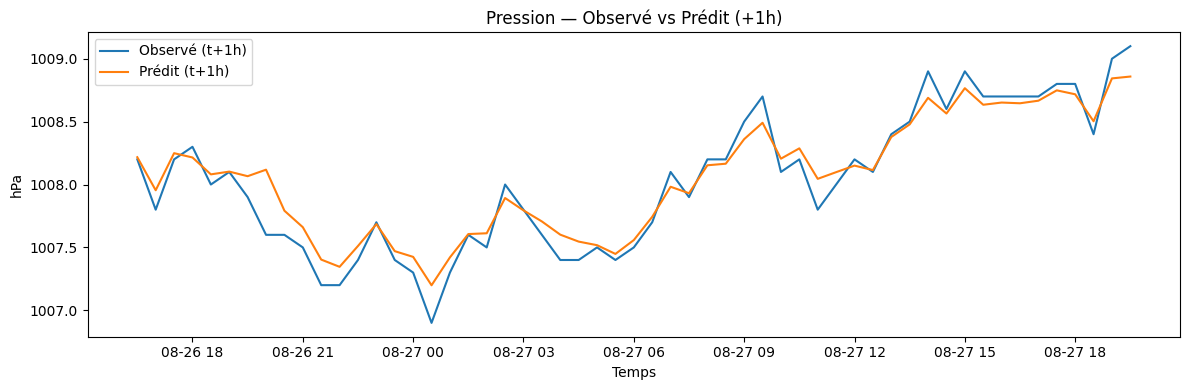

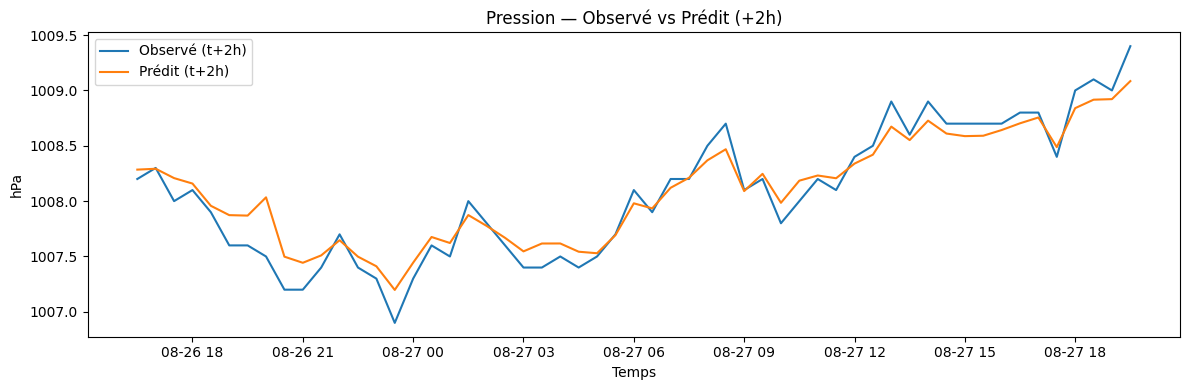

In [13]:
plt.figure(figsize=(12, 4))
plt.plot(
    df_compare["timestamp"], df_compare["pression_t+2_obs"], label="Observé (t+1h)"
)
plt.plot(
    df_compare["timestamp"], df_compare["pression_t+2_pred"], label="Prédit (t+1h)"
)
plt.title("Pression — Observé vs Prédit (+1h)")
plt.xlabel("Temps")
plt.ylabel("hPa")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "pression_obs_vs_pred_t+1h.png"), dpi=120)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(
    df_compare["timestamp"], df_compare["pression_t+4_obs"], label="Observé (t+2h)"
)
plt.plot(
    df_compare["timestamp"], df_compare["pression_t+4_pred"], label="Prédit (t+2h)"
)
plt.title("Pression — Observé vs Prédit (+2h)")
plt.xlabel("Temps")
plt.ylabel("hPa")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "pression_obs_vs_pred_t+2h.png"), dpi=120)
plt.show()


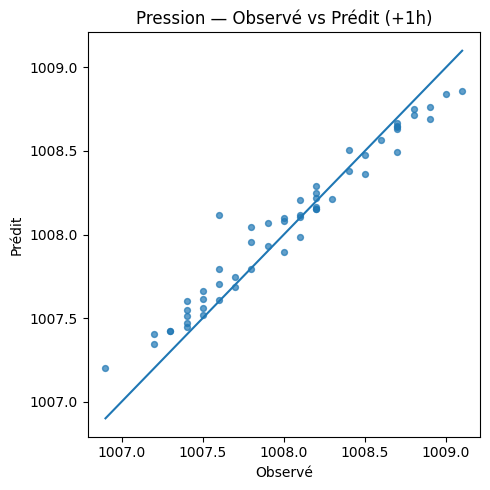

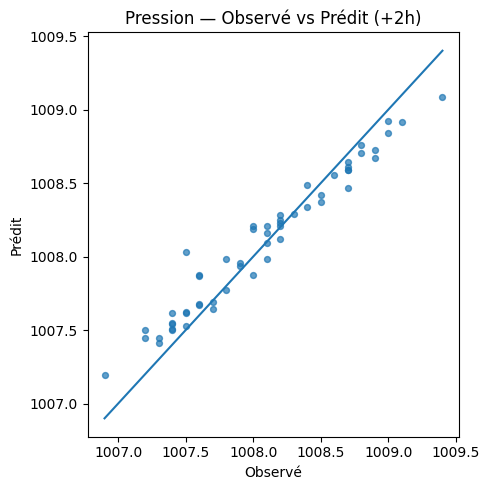

In [14]:
import numpy as np


def scatter_obs_pred(y_obs, y_pred, title, outpath):
    plt.figure(figsize=(5, 5))
    plt.scatter(y_obs, y_pred, s=18, alpha=0.7)
    
    minv = float(min(np.min(y_obs), np.min(y_pred)))
    maxv = float(max(np.max(y_obs), np.max(y_pred)))
    plt.plot([minv, maxv], [minv, maxv])
    plt.xlabel("Observé")
    plt.ylabel("Prédit")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(outpath, dpi=120)
    plt.show()


scatter_obs_pred(
    df_compare["pression_t+2_obs"].to_numpy(),
    df_compare["pression_t+2_pred"].to_numpy(),
    "Pression — Observé vs Prédit (+1h)",
    os.path.join(FIG_DIR, "pression_scatter_t+1h.png"),
)
scatter_obs_pred(
    df_compare["pression_t+4_obs"].to_numpy(),
    df_compare["pression_t+4_pred"].to_numpy(),
    "Pression — Observé vs Prédit (+2h)",
    os.path.join(FIG_DIR, "pression_scatter_t+2h.png"),
)


In [15]:
df_courant = df_model.copy()
preds_press = predire_pression(df_courant)
preds_press


{'niveaux': {'pression_t+1h': 1008.9, 'pression_t+2h': 1009.1},
 'deltas': {'dP_+1h': 0.3, 'dP_+2h': 0.5}}

## Synthèse 

### 1. Objectifs
- Prévoir la **pression intérieure** de la salle aux horizons :
  - **+1h** (t+2 pas de 30 minutes),
  - **+2h** (t+4 pas de 30 minutes).
- Prévoir également la **variation (delta)** de la pression aux mêmes horizons pour suivre les tendances locales.

### 2. Données & cibles
- Données en entrée : features enrichies créées dans le Notebook 02 (`capteur_C013_features.csv`).
- Cibles :
  - **Niveaux** : `pression_t+2`, `pression_t+4`.
  - **Deltas** : `dP_t+2`, `dP_t+4`.
- Les lignes en fin de série sans labels ont été supprimées.

### 3. Features utilisées
- Signaux instantanés : température, température extérieure, humidité, pression, occupation.
- Contexte temporel : ouverture de la salle, sinus/cosinus de l’heure, jour de semaine, weekend.
- Mémoire (lags) : pression, température, humidité, occupation (t-30 min, t-1h).
- Tendances locales : moyennes glissantes sur 1h et 3h.
- Interactions : ratio d’occupation, écart de température int/ext, ouverture × occupation.

### 4. Modèles entraînés
- **Baseline linéaire** : Ridge multi-sorties.
- **Modèle principal** : RandomForestRegressor multi-sorties avec hyperparamètres tunés :
  - `n_estimators=400`, `max_depth=20`, `min_samples_leaf=1`, `max_features="sqrt"`.
- Validation avec **TimeSeriesSplit (5 folds)**.

### 5. Évaluation (MAE / RMSE)
- Les scores (MAE, RMSE arrondis à 1 décimale) montrent que le modèle capture correctement les variations de pression.
- Les deltas sont plus difficiles à prédire que les niveaux, mais apportent une indication de tendance.
- Graphiques générés :
  - Séries temporelles **observé vs prédit** (t+1h et t+2h).
  - Scatter avec diagonale y=x pour évaluer la cohérence.
